# NoteBook to Make Descriptives

This notebook is for looking at final population zonal stats data

In [1]:
from rasterstats import zonal_stats
import rasterio
import geopandas as gpd
import operator
import numpy as np
import pandas as pd
import matplotlib 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from functools import reduce

# Functions

In [2]:
def city_search(gpd_df, city_list, country):
    """ function will print out city name and population for a subset of a gridded dataset gpd
    requires data frame, list of cities, and country of interest
    """
    gpd_df_sub = gpd_df[gpd_df['country'] == country]
    
    for index, row in gpd_df_sub.iterrows():
        for city in city_list:
            if row['city'] == city:
                print(city)
                print(round(row['PopTot']))

In [3]:
def str_id(gpd_df):
    """
    Function makes a new col with a unique lat-lon string to identify each osm point & drops duplicates
    Function also makes
    """

    
    print(gpd_df.shape)
    
    lat_string = gpd_df.lat.astype(str)
    lon_string = gpd_df.lon.astype(str)
    gpd_df['str_id'] = lat_string.astype(str)+lon_string.astype(str)
    
    print(gpd_df.shape)


In [4]:
def dup_drop(gpd_in, col, keep_dup):
    """ 
    function drops duplicates based on a column from a pd data frame
    requires pd df out string, pd df, col name, and which dup to keep
    returns new gpd_df
    """
    
    gpd_out = gpd.GeoDataFrame()
    
    print(gpd_in.shape)
    
    gpd_out = gpd_in.drop_duplicates(col, keep = keep_dup)
    
    print(gpd_out.shape)

    return gpd_out

    

In [5]:
def df_merge(df_left, df_right):
    
    pd_out = pd.DataFrame()
    pd_out = pd.merge(df_left[['str_id', 'PopTot']], df_right[['str_id', 'PopTot']], on='str_id', how = 'inner')
    
    left_pop = pd_out.PopTot_x.astype(str)
    right_pop = pd_out.PopTot_y.astype(str)
    pd_out['pop_id'] = left_pop.astype(str)+right_pop.astype(str)

    return pd_out

In [ ]:
def p_X_gt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data>=x)/n_data for x in X ])

def p_X_lt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data<=x)/n_data for x in X ])

# Data

In [6]:
# File paths

data_raw = '/Users/cascade/Github/NTL/data/raw/'
data_temp = '/Users/cascade/Github/NTL/temp_data/'
data_interim = '/Users/cascade/Github/NTL/data/interim/'
ms_data = '/Users/cascade/Github/NTL/temp_data/MS_Data/'
erl_data = '/Users/cascade/Github/NTL/temp_data/ERL_data/'
downloads = '/Users/cascade/Downloads/'

In [7]:
# Data

GHS2000 = gpd.read_file(erl_data+'GHS_POP_GPW42000_final20190122.shp')
GHS2015 = gpd.read_file(erl_data+'GHS_POP_GPW42015_final20190122.shp')
WP2000 = gpd.read_file(erl_data+'AFR_PPP_2000_adj_v2_final20190122.shp')
WP2015 = gpd.read_file(erl_data+'AFR_PPP_2015_adj_v2_final20190122.shp')
LS2015 = gpd.read_file(erl_data+'WPE_1KM_2016_final20190122.shp')
WPE2016 = gpd.read_file(erl_data+'LS15_final20190122.shp')

In [8]:
# List of datasets

datasets_in = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]

# Group Data

In [ ]:
# Drop Doubles based on OSM Lat/Lon

GHS2000_drop = dup_drop(GHS2000, 'str_id', 'first')
WP2000_drop = dup_drop(WP2000, 'str_id', 'first')

GHS2015_drop = dup_drop(GHS2015, 'str_id', 'first')
WP2015_drop = dup_drop(WP2015 , 'str_id', 'first')
LS2015_drop = dup_drop(LS2015 , 'str_id', 'first')
WPE2016_drop = dup_drop(WPE2016 , 'str_id', 'first')

In [ ]:
GHS2015_pop = GHS2015_drop[['str_id','PopTot']]
WP2015_pop = WP2015_drop[['str_id','PopTot']]
LS2015_pop = LS2015_drop[['str_id','PopTot']]
WPE2016_pop = WPE2016_drop[['str_id','PopTot']]

data_frames = [GHS2015_pop, WP2015_pop, LS2015_pop, WPE2016_pop]

df2015_merged = reduce(lambda  left,right: pd.merge(left,right,on=['str_id'], how='inner'), data_frames)

print(len(df2015_merged))
df2015_merged.head(4)



In [ ]:
df2015_merged.columns = ['str_id', 'GHS15_Pop', 'WP15_Pop', 'LS15_Pop', 'WPE2016_pop' ]
df2015_merged.head()

In [ ]:
df_2015_GHS_WP = df2015_merged[['WPE2016_pop','LS15_Pop']]
print(df_2015_GHS_WP.shape)


df_2015_GHS_WP = df_2015_GHS_WP.drop_duplicates(keep='first')
print(df_2015_GHS_WP.shape)


In [ ]:
stats.pearsonr(df_2015_GHS_WP['WPE2016_pop'], df_2015_GHS_WP['LS15_Pop'])

In [ ]:
df_2015_GHS_WP.dtypes

In [ ]:
# Pairwise scatter plots

fig = plt.figure()
ax = plt.gca()
ax.scatter(df_2015_GHS_WP['WPE2016_pop'], df_2015_GHS_WP['LS15_Pop'] , c='blue', alpha=0.05, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('ESRI - WPE 2016')
plt.ylabel('LandScan 2015')

#fig.savefig('/Users/cascade/Desktop/'+'WPE16-LS15.png', dpi=700)

In [ ]:
#axl = pd.scatter_matrix(df2015_merged, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

import seaborn as sns
corr = df2015_merged.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
import matplotlib.pyplot as plt

#matplotlib.pyplot.scatter(df_merge['PopTot_x'], df_merge['PopTot_y'])

fig = plt.figure()
ax = plt.gca()
ax.scatter(test_df_drop['PopTot_x'], test_df_drop['PopTot_y'] , c='blue', alpha=0.05, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('WPE 2016')
plt.ylabel('World Pop 2015')

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(test_df_drop['x'], test_df_drop['y'], c='blue', alpha=0.1, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('WPE 2016')
plt.ylabel('World Pop 2015')

In [ ]:
from scipy import stats
xA = df_merge['PopTot_x']
yA = df_merge['PopTot_y']

result = stats.pearsonr(xA, yA) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
result

In [ ]:
from scipy import stats
xR = test_df_drop['x']
yR = test_df_drop['y']

result = stats.pearsonr(xR, yR) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
result

In [ ]:
test_df_min = test_df_drop[test_df_drop['x']<=1000000]
print(len(test_df_min))
test_df_min = test_df_drop[test_df_drop['y']<=1000000]
print(len(test_df_min))

In [ ]:
test_df_min[test_df_min['y']>=1000000]

In [ ]:
xW = test_df_min['x']
yW = test_df_min['y']

result = stats.pearsonr(xW, yW) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
result

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(test_df_min['x'], test_df_min['y'], c='blue', alpha=0.1, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('WPE 2016')
plt.ylabel('World Pop 2015')

# Distrubutions

In [21]:
# add col for concat, drop FID duplicates

datasets_string = ['GHS2000', 'GHS2015', 'WP2000', 'WP2015', 'LS2015', 'WPE2016']

# for i, dataset in enumerate(datasets_in):
    
#     dataset['dataset'] = datasets_string[i]
#     dataset = dup_drop(dataset, 'FID', 'first')

WPE2016['dataset'] = 'WPE2016'
WPE2016 = dup_drop(WPE2016, 'FID', 'first')

(5552, 11)
(4347, 11)


In [76]:
# drop cities with less than 5000 
GHS2015 = GHS2015[GHS2015['PopTot']>=5000] 
WP2015 = WP2015[WP2015['PopTot']>=5000] 
LS2015 = LS2015[LS2015['PopTot']>=5000] 
WPE2016 = WPE2016[WPE2016['PopTot']>=5000] 


datasets2015 = [GHS2015, WP2015, LS2015, WPE2016]


datasets15_concat = pd.concat(datasets2015, ignore_index=True)

# datasets_concat = pd.concat(datasets_in, ignore_index=True)

In [77]:
datasets15_concat.shape

(14020, 11)

In [81]:
min(WPE2016['PopTot'])

5000.0

In [ ]:
sns.set(font_scale=3)
ax = sns.boxplot(x = 'PopTot', y = 'dataset', data = datasets15_concat)
ax.set(xscale="log") 
plt.xlabel('Population')
plt.ylabel('')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

#fig.savefig('/Users/cascade/Desktop/'+'data15-hist.png', dpi=700)

In [86]:
datasets2015 = [GHS2015, WP2015, LS2015, WPE2016]


GHS2015_sort = GHS2015['PopTot'].sort_values()
X0, y0 = p_X_gt_x(GHS2015_sort)

WP2015_sort = WP2015['PopTot'].sort_values()
X1, y1 = p_X_gt_x(WP2015_sort)

LS2015_sort = LS2015['PopTot'].sort_values()
X2, y2 = p_X_gt_x(LS2015_sort )

WPE2016_sort = WPE2016['PopTot'].sort_values()
X3, y3 = p_X_gt_x(WPE2016_sort)


In [ ]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(X0, y0, label ='GHS2015')
ax.plot(X1, y1, label ='WP2015')
ax.plot(X2, y2, label ='LS2015')
ax.plot(X3, y3, label ='WPE2016')
plt.xscale('log')
plt.title('Inverse cumulative distribution of city sizes by dataset')
plt.xlabel('x(Population)')
plt.ylabel('P[X>=x]')
ax.legend()
fig.set_size_inches(18.5, 10.5)


In [109]:
#GHS2000.loc[(GHS2000['PopTot'] > 5000) & (GHS2000['PopTot'] < 10000), 'PopTot'].sum()
test = GHS2015[GHS2015['PopTot'] <5000000]

a =test.loc[(test['PopTot'] > 1000000), 'PopTot'].sum()
                                         
                                          
#GHS2000.loc[GHS2000['PopTot'] <50000 & GHS2000['PopTot'] >5000, 'PopTot'].sum()

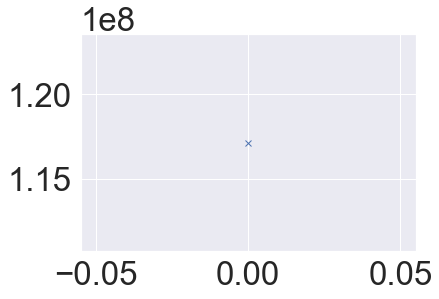

In [115]:
import numpy as np
import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
 # just as an example array
pp.plot(a, 'x')
pp.show()

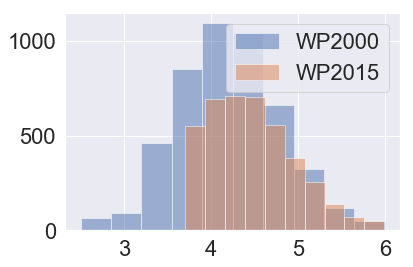

In [73]:
WPE2016.head()

a = GHS2015[GHS2015['PopTot']>0]
a = GHS2015[GHS2015['PopTot']<1000000]
b = GHS2000[GHS2000['PopTot']>0]
b = GHS2000[GHS2000['PopTot']<1000000]


plt.hist(np.log10(b['PopTot']), alpha=0.5, label='WP2000')
plt.hist(np.log10(a['PopTot']), alpha=0.5, label='WP2015')
#plt.hist(np.log10(LS2015['PopTot']), alpha=0.5, label='x')
#plt.hist(np.log10(a['PopTot']), alpha=0.5, label='x')



plt.legend(loc='upper right')
# plt.show()


In [42]:
min(GHS2015['PopTot'])

300.4884033203125

# Old Code

In [ ]:
# df_test_a = WP2015[['osm_id', 'PopTot']]


# df_test_b = GHS2015[['osm_id', 'PopTot']]
# print(df_test_b.shape)
# print(df_test_a.shape)

# df_test_a_drop = df_test_a.drop_duplicates('osm_id', keep=False)
# df_test_b_drop = df_test_b.drop_duplicates('osm_id', keep=False)
# print(df_test_b_drop.shape)
# print(df_test_a_drop.shape)

In [ ]:
# find duplicates

# dupsA = pd.concat(g for _, g in test_df.groupby("str_id") if len(g) > 1)
# dupsA

In [ ]:
# x = df_merge['PopTot_x']
# y = df_merge['PopTot_y']
# str_id_merge = df_merge['str_id']
# test_df = pd.DataFrame()
# test_df['x'] = x
# test_df['y'] = y
# test_df['str_id_merge'] = str_id_merge



# test_df['x_string'] = test_df.x.astype(str)
# test_df['y_string'] = test_df.y.astype(str)
# test_df['str_id'] = test_df.x_string.astype(str)+test_df.y_string.astype(str)

In [ ]:
#axl = pd.scatter_matrix(df2015_merged, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

# import seaborn as sns
# corr = df2015_merged.corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

In [ ]:
# import matplotlib.pyplot as plt

# #matplotlib.pyplot.scatter(df_merge['PopTot_x'], df_merge['PopTot_y'])

# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(test_df_drop['PopTot_x'], test_df_drop['PopTot_y'] , c='blue', alpha=0.05, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('WPE 2016')
# plt.ylabel('World Pop 2015')

In [ ]:
# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(test_df_drop['x'], test_df_drop['y'], c='blue', alpha=0.1, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('WPE 2016')
# plt.ylabel('World Pop 2015')

In [ ]:
# from scipy import stats
# xA = df_merge['PopTot_x']
# yA = df_merge['PopTot_y']

# result = stats.pearsonr(xA, yA) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
# result

In [ ]:
# from scipy import stats
# xR = test_df_drop['x']
# yR = test_df_drop['y']

# result = stats.pearsonr(xR, yR) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
# result

In [ ]:
# test_df_min = test_df_drop[test_df_drop['x']<=1000000]
# print(len(test_df_min))
# test_df_min = test_df_drop[test_df_drop['y']<=1000000]
# print(len(test_df_min))

In [ ]:
# test_df_min[test_df_min['y']>=1000000]

In [ ]:
# xW = test_df_min['x']
# yW = test_df_min['y']

# result = stats.pearsonr(xW, yW) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
# result

In [ ]:
# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(test_df_min['x'], test_df_min['y'], c='blue', alpha=0.1, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('WPE 2016')
# plt.ylabel('World Pop 2015')